In [434]:
"""
Created By    : Jared W. Marquis
Creation Date : 01 August 2022
Course        : ATSC 528 - Atmospheric Data Analysis
Assignment    : #02 - Successive Corrections

Purpose:
Script to take sparse upper air observations and analyze them on a
polar stereographic map projection using successive corrections.
[PUT MORE INFORMATION HERE - I.E., WHAT SPECIFIC THING IS BEING DONE]

"""
__author__    = "Jared W. Marquis"
__contact__   = "jared.marquis@und.edu"

In [435]:
### Import Required Modules (shouldn't need to change) ###
import numpy as np                 #numpy for math
import matplotlib.pyplot as plt    #matplotlib for plotting
import cartopy.crs as ccrs         #cartopy for plotting on map
import cartopy.feature as cfeature #cartopy basic shapefiles

In [436]:
### Read in observations ###
directory = "/Users/techadmin/ATMO528/ATSC528/"
filename = "RAOBs_201903131200.txt"
data_str = np.loadtxt("RAOBs_201903131200.txt", delimiter = ',', dtype = str)
# file = open(directory + filename)
# data = file.read()
latitude = data_str[:, 1].astype(float)
longitude = data_str[:, 2].astype(float)
g_h = data_str[:, 3].astype(float)
print(g_h.shape)

#print(latitude)

(135,)


In [437]:
### Set up analysis map with a 22x28 rectangular grid of points ###
phi0 = np.radians(60) #phi naught , 60N
psi0 = np.radians(90)-phi0
lambda0 = -115 #lamda naught, 115W
delx = 1.27 #cm
dely = 1.27 #cm
x0 = 18.90 #cm
y0 = -6.30 #cm 
x_range = np.arange(22)
y_range = np.arange(28)
#print(x_range)
x_calculation = x0 + (delx*x_range) 
y_calculation = y0 + (dely*y_range)
rho = 6371000 #meters
map_scale = 1/15000000 #15 million

x = np.array(x_calculation)
y = np.array(y_calculation)
x_g, y_g = np.meshgrid(x,y)
#print(x_g.shape) 

(28, 22)


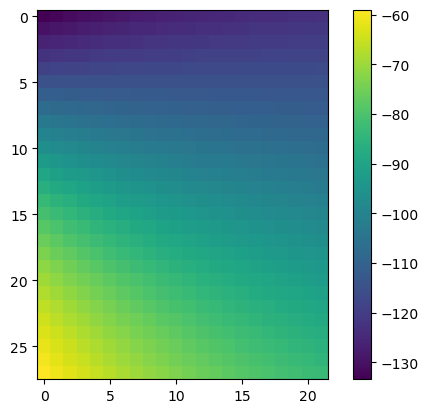

In [438]:
### convert obs lat/long to x,y ###
x_g_m = x_g/100
y_g_m = y_g/100
print(x_g_m.shape)
numer = (((((x_g_m)/map_scale)**2)+(((y_g_m)/map_scale)**2))**(1/2))
denom = rho*(1+(np.cos(psi0)))
psi = (np.pi/2) - (2*(np.arctan(numer/denom))) #x-cord, y-cord to latitude?
psi = np.degrees(psi)

lamda = (np.degrees(np.arctan(y_g_m/x_g_m)))+lambda0 #x-cord, y-cord to longitude?
# print(lamda)

# print(psi,lamda)
plt.imshow(lamda)
plt.colorbar()

In [439]:
### Create function for Cressman Analysis ###
sigma = ((1+np.sin(np.radians(60)))/(1+np.sin(np.radians(latitude))))

x_ob = rho*sigma*(np.cos(np.radians(latitude)))*(np.cos(np.radians(longitude)+np.radians(115))) #converting coords to x
y_ob = rho*sigma*(np.cos(np.radians(latitude)))*(np.sin(np.radians(longitude)+np.radians(115))) #converting coords to y
# print(y_ob.shape)
x_ob = x_ob * map_scale *100 #now in cm
y_ob = y_ob * map_scale *100
x_ob_cm = x_ob
y_ob_cm = y_ob
# x_ob = x_ob/100
# y_ob = y_ob/100
# print('x_ob', x_ob)
# print('y_ob', y_ob)
dmin = 0.0

for i in range(len(x_ob)):
      # distance_analysis_to_ob = np.sqrt(((x_g_m[i,j]-x_ob)**2)+((y_g_m[i,j]-y_ob)**2))
      distance_ob_to_ob = np.sqrt(((x_ob[i]-x_ob)**2)+((y_ob[i]-y_ob)**2))
      # print("with zero =",len(distance_ob_to_ob))
      distance_ob_to_ob = np.delete(distance_ob_to_ob,i)
      #distance_ob_to_ob = distance_ob_to_ob[distance_ob_to_ob>1e-10] #------------told in class that dmin = avg minimum distance between obs.
      # print("without zero =",len(distance_ob_to_ob))
      #print('distance_ob_to_ob', distance_ob_to_ob)
      #print('distance_ob_to_ob_shape', distance_ob_to_ob.min())
      dmin = dmin + np.amin(distance_ob_to_ob)   
      # print('dmin is', dmin)
      #dmin = distance_ob_to_ob.min()
      # print(temp)

dmin = dmin/len(x_ob)
print('dmin', dmin)

# dmin_cm = dmin *100 #converting to cm?
dmin_cm = dmin
#print('dmin_cm', dmin_cm)

R1 = 4*dmin_cm
R2 = 2.5*dmin_cm
R3 = 1.5*dmin_cm
#print('R1', R1)

def cressman(R, dik):
        weight = np.zeros(dik.shape)
        for i in range(len(dik)):
            if dik[i] <R:
                numerator = (R**2) - (dik[i]**2)
                denominator = (R**2) + (dik[i]**2)
                weight[i] = numerator / denominator #renamed weight as something such as easier naming for later
                # print('dik**2', dik**2)
                #print('numerator', numerator)
                #print('denominator', denominator)
                # print('weight', weight)
            #else:
            #        numerator = (R**2) - (dik**2)
            #        denominator = (R**2) + (dik**2)
            #        print('R**2', R**2)
            #        print('numerator', numerator)
            #        print('denominator', denominator)
            #        weight=0
        #print('weight', weight)
        return weight

x_g_cm = x_g_m*100
y_g_cm = y_g_m*100
fa = np.zeros((28,22))
w = []
for i in range(len(x_g_cm)):
    for j in range(len(x_g_cm[i])):
              distance_analysis_to_ob = np.sqrt(((x_g_cm[i,j]-x_ob)**2)+((y_g_cm[i,j]-y_ob)**2))
              dik = distance_analysis_to_ob[distance_analysis_to_ob !=0]
              #dik = dik[dik>R1]
              #print('dik**2',dik**2)
              #w.append(cressman(R1, dik))
              w = cressman(R1,dik)
              #print('w', w)
              #print('w shape', w.shape)
              fa[i,j] = (np.nansum(w*g_h)/np.nansum(w))
              

#print('D_min =',dmin)
print('fa', fa)
# plt.contour(fa)


dmin 2.55487008200714
fa [[5299.47830463 5316.07234405 5332.21518515 5350.20150651 5370.8410277
  5391.58259492 5408.06617806 5422.31189783 5436.43249375 5448.69778804
  5459.01592307 5467.02728059 5477.37903863 5490.55717128 5502.3450854
  5515.07271135 5529.06977571 5542.92724291 5558.73839687 5575.14452015
  5587.70030511 5599.79042578]
 [5302.29461627 5317.49902778 5333.88503499 5351.10825178 5370.25953266
  5387.44398022 5403.02143452 5417.27804412 5432.14677208 5442.92852243
  5452.20610665 5459.89849732 5471.1680421  5483.09270124 5494.14919822
  5506.80853123 5520.62137083 5534.62703412 5548.45975024 5564.23409088
  5577.39412193 5587.83527343]
 [5300.20871409 5314.46309884 5331.29779001 5349.25224589 5366.77517287
  5383.49602176 5398.84569983 5413.02805422 5426.50052174 5437.89769706
  5446.42711208 5453.66799026 5464.56414954 5476.28532028 5487.28417507
  5499.76390774 5512.88064664 5526.6308383  5539.07452569 5553.64707812
  5568.54406701 5580.47808571]
 [5292.40093529 5306

In [440]:
### Perform 500mb geopotential height analyses using a Cressman weighting Function###
#Use radii of influence 4, 2.5, 1.5 *dmin


# print('dmin', dmin)
# print('dik', dik)

# analysis_list = []
# for i in range(len(x_g_cm)):
    # for j in range(len(x_g_cm[i])):
        # num = sum(w[i]*g_h)
        # den = sum(w[i])
        # analysis = num/den
        # analysis_list.append(analysis)
# analysis_list = np.array(analysis_list).reshape(28,22)

print(fa.shape)
        

cressman_1 = cressman(R1, dik)
cressman_2 = cressman(R2, dik)
cressman_3 = cressman(R3, dik)

#print('cressman_1', cressman_1)

(28, 22)


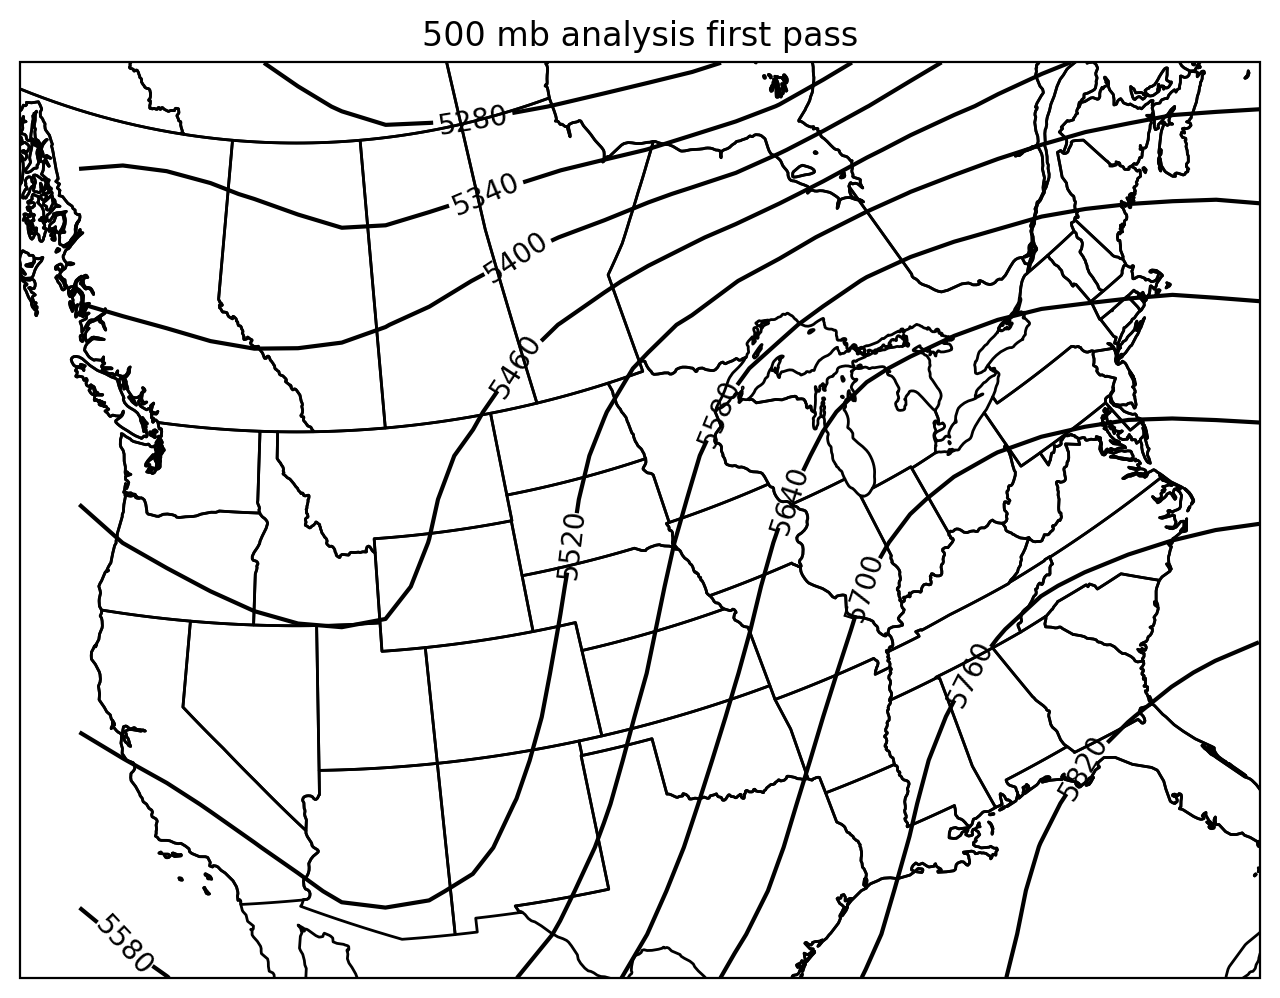

In [441]:
### First analysis, no successive corrections ###
# analysis_1 = np.sum(w*dik*g_h)/(np.sum(w*dik))
# print(analysis_1)


proj = ccrs.Stereographic(central_longitude=-115,central_latitude=90,true_scale_latitude=60)
fig = plt.figure(figsize=(8,8),dpi=200)
ax1 = fig.add_subplot(111,projection=proj)
ax1.add_feature(cfeature.STATES)
ax1.add_feature(cfeature.COASTLINE)

#plot analysis (MAY NEED TO CHANGE VARIABLE NAMES/INDICES)#
cs1 = ax1.contour(lamda,psi,fa,colors='k',levels=np.arange(0,8000,60),transform=ccrs.PlateCarree())
plt.clabel(cs1,levels=np.arange(0,8000,60))
plt.title("500 mb analysis first pass")
plt.show()

In [442]:
### Create function for bilinear interpolation ###
# g_h_append = []
# g_h_append.append(g_h)
# g_h_append.append((28,22))
# g_h_append = np.array(g_h_append)
# print('g_h_append', g_h_append.shape)

# def bilienar_interp(x_ob_cm, y_ob_cm):
#     # x_k = x_ob*100
#     # y_k = y_ob*100
#     x_k = x_ob_cm
#     y_k = y_ob_cm
#     index_x = ((x_k - x0) / delx)
#     index_y = ((y_k - y0) / dely)

#     #flip x,y to j,i because rows then columns in python
#     BLindex_j = int(np.floor(index_x))
#     BLindex_i = int(np.floor(index_y))

#     # print(BLindex_i,BLindex_i+2)
#     four_xs = x_g_cm[BLindex_i:BLindex_i+2,BLindex_j:BLindex_j+2]
#     four_ys = y_g_cm[BLindex_i:BLindex_i+2,BLindex_j:BLindex_j+2]
#     four_ghs = fa[BLindex_i:BLindex_i+2,BLindex_j:BLindex_j+2]

#     dxk = x_ob_cm - four_xs
#     dyk = y_ob_cm - four_ys

#     print('four_ghs', four_ghs)

#     a_matrix = np.array([
#              [1, np.mean(dxk), np.mean(dyk), np.mean(dxk*dyk)],
#              [np.mean(dxk), np.mean(dyk**2), np.mean(dxk*dyk), np.mean((dxk**2)*dyk)],
#              [np.mean(dyk), np.mean(dxk*dyk), np.mean(dyk**2), np.mean(dxk*(dyk**2))],
#              [np.mean(dxk*dyk), np.mean((dxk**2)*dyk), np.mean(dxk*(dyk**2)), np.mean((dxk**2)*(dyk**2))]
#     ])
    
#     print(a_matrix)

#     b_matrix = np.array([
#                 f0,
#                  np.mean(dxk),
#                  np.mean(dyk),
#                  np.mean(dxk*dyk)])
    

#     coef = np.linalg.inv(a_matrix) @ b_matrix

#     BLvalue = fa[BLindex_j, BLindex_i]
#     # BLvalue = g_h[BLindex_j]
#     return coef

# # for i in range(len(fa)):
# #     for j in range(len(fa)):
# #         f0 = fa[i, j]
# #         test = bilienar_interp(x_ob_cm, y_ob_cm, f0)

# test = bilienar_interp(x_ob_cm, y_ob_cm)
# print(x_ob_cm[2])
# print(y_ob_cm[2])
# print ('test', test)

def bilienar_interp(x_ob_cm, y_ob_cm):
    # x_k = x_ob*100
    # y_k = y_ob*100
    x_k = x_ob_cm
    y_k = y_ob_cm
    index_x = ((x_k - x0) / delx)
    index_y = ((y_k - y0) / dely)
    # print('index_x', index_x)
    # print('index_y', index_y)
    #flip x,y to j,i because rows then columns in python
    # BLindex_j = int(np.floor(index_x))
    # BLindex_i = int(np.floor(index_y))
    x1 = int(np.floor(index_x))
    y1 = int(np.floor(index_y))
    x2 = int(np.ceil(index_x))
    y2 = int(np.ceil(index_y))
    if ((x1>21) or (x1<0) or (x2>21) or (x2<0) or (y1<0) or (y1>27) or (y2<0) or (y2>27)):
        #print('fuck')

        warr = np.zeros((28,22))
        for i in range(len(x_g_cm)):
            for j in range(len(x_g_cm[i])):
                distance_ob_to_analysis = np.sqrt(((x_ob_cm-x_g[i, j])**2)+((y_ob_cm-y_g[i, j])**2))
                dik = distance_ob_to_analysis
                if distance_ob_to_analysis<R1:
                    numerator = (R1**2) - (dik**2)
                    denominator = (R1**2) + (dik**2)
                    warr[i, j] = numerator/denominator
        booger = np.sum(warr*fa)/np.sum(warr)
        if np.sum(warr)>0:
            return booger
        else:
            return np.nan

    x1v = x_calculation[x1]
    y1v = y_calculation[y1]
    x2v = x_calculation[x2]
    y2v = y_calculation[y2]


    a_matrix = np.array([[
        1, x1v, y1v, x1v*y1v],
        [1, x1v, y2v, x1v*y2v],
        [1, x2v, y1v, x2v*y1v],
        [1, x2v, y2v, x2v*y2v]])
    
    # print(a_matrix)


    b_matrix = np.array([
                fa.T[x1, y1],
                fa.T[x1, y2],
                fa.T[x2, y1],
                fa.T[x2, y2]])
    

    coef = np.linalg.inv(a_matrix) @ b_matrix

    pt = np.asarray([1,x_ob_cm, y_ob_cm, x_ob_cm * y_ob_cm])

    result = pt@coef

    return result

# for i in range(len(fa)):
#     for j in range(len(fa)):
#         f0 = fa[i, j]
#         test = bilienar_interp(x_ob_cm, y_ob_cm, f0)

test = bilienar_interp(x_ob_cm[0], y_ob_cm[0])
thing = np.zeros(135)
for i in range(135):
    thing[i] = bilienar_interp(x_ob_cm[i], y_ob_cm[i])
print('thing', thing.round(2))
print(x_ob_cm[0])
print(y_ob_cm[0])
print ('test', test)

thing [5494.09 5561.01 5385.3  5385.5  5310.02 5283.78     nan 5307.41 5330.57
 5515.66     nan 5494.31 5394.8  5408.96 5249.55 5499.78 5295.67 5275.54
 5411.6  5315.57 5334.28 5299.33 5476.82 5419.85 5514.51 5386.79 5517.71
 5537.56 5321.93 5699.9  5309.85 5520.92 5632.3  5583.96 5320.47 5369.57
 5640.93 5724.49 5299.48 5507.03 5780.17 5745.22 5452.47 5720.05 5300.38
 5663.82 5725.91 5532.47     nan 5629.36 5795.12 5704.59 5584.03 5504.43
 5675.68 5522.89 5503.61 5672.66 5673.85 5653.47 5550.05 5864.77 5314.93
 5785.61 5497.31 5628.24 5683.99 5454.69 5480.9  5635.84 5750.26 5601.78
 5707.05 5715.3  5687.76 5543.72     nan 5762.38 5822.51     nan     nan
 5545.81 5751.11 5716.83 5466.57 5715.69 5616.14 5743.37 5832.69 5474.54
 5756.71 5832.32 5588.43 5604.55 5709.13 5825.3  5537.86 5838.71 5543.48
 5512.76 5603.8  5642.04 5659.33     nan 5432.65 5299.48 5646.93 5672.54
 5698.84 5502.12 5483.85 5464.97 5646.44 5735.35     nan     nan 5674.83
 5722.44 5786.5  5465.92 5455.92     nan 5846

/var/folders/ph/gnz9scgj5491zgp3rggx75kr0000gp/T/ipykernel_12875/3325644973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  booger = np.sum(warr*fa)/np.sum(warr)


In [450]:
### Next Analyses ###
f_a_2 = np.zeros(135)
for i in range(len(f_a_2)):
    f_a_2[i] = bilienar_interp(x_ob_cm[i], y_ob_cm[i])
#print(np.sum(np.isnan(f_a_2)))
# print(x_ob_cm.shape)
# print(fa.shape)
# print(dik.shape)

fa_new = np.zeros((28,22))
for i in range(len(x_g_cm)):
    for j in range(len(x_g_cm[i])):
              distance_analysis_to_ob = np.sqrt(((x_g_cm[i,j]-x_ob)**2)+((y_g_cm[i,j]-y_ob)**2))
              dik = distance_analysis_to_ob[distance_analysis_to_ob !=0]
              #dik = dik[dik>R1]
              #print('dik**2',dik**2)
              #w.append(cressman(R1, dik))
              w2 = cressman(R2,dik)
              fa_new[i, j] = fa[i,j] + np.nansum(w2*(g_h-thing))/np.nansum(w2)
print('fa_new', fa_new)
print('fa[0,0]', fa[0, 0])

varr = np.sqrt(np.nansum((g_h-thing)**2)/len(thing[~np.isnan(thing)]))
print(varr)
#print(R2)

fa_new [[5280.95019866 5311.69870482 5336.06809441 5362.78181643 5389.55511253
  5417.21749181 5438.72319926 5454.5493874  5467.01342956 5479.49538121
  5490.46229318 5499.0925262  5513.48809125 5532.13980401 5551.97526259
  5572.21819198 5595.38173724 5619.52312968 5649.0543301  5670.62187298
  5685.1504914  5698.26631543]
 [5277.8964953  5305.45681776 5330.21497855 5356.6904854  5382.26576899
  5405.0856364  5424.17136809 5440.37582767 5455.75968042 5464.53741503
  5473.07762981 5480.89765164 5494.06031547 5511.29947223 5526.69675445
  5548.37417327 5576.68223763 5599.34816742 5623.13520786 5651.25867272
  5674.03039874 5686.73748321]
 [5265.46421941 5291.51786722 5315.93106459 5341.63718788 5367.03317944
  5391.42249013 5409.11124298 5425.51067648 5438.37777671 5448.76836078
  5456.21566111 5461.15436617 5473.03087007 5487.62810822 5501.69820414
  5524.88108295 5553.58439863 5580.24836563 5604.01723301 5630.90984248
  5655.12999074 5679.32134244]
 [5248.14300671 5271.86826041 5297.4

/var/folders/ph/gnz9scgj5491zgp3rggx75kr0000gp/T/ipykernel_12875/3325644973.py:90: RuntimeWarning: invalid value encountered in scalar divide
  booger = np.sum(warr*fa)/np.sum(warr)


In [444]:
### Calculate Analysis Differences
f_a_diff = fa_new - fa
print(f_a_diff)

[[-1.85281060e+01 -4.37363923e+00  3.85290926e+00  1.25803099e+01
   1.87140848e+01  2.56348969e+01  3.06570212e+01  3.22374896e+01
   3.05809358e+01  3.07975932e+01  3.14463701e+01  3.20652456e+01
   3.61090526e+01  4.15826327e+01  4.96301772e+01  5.71454806e+01
   6.63119615e+01  7.65958868e+01  9.03159332e+01  9.54773528e+01
   9.74501863e+01  9.84758897e+01]
 [-2.43981210e+01 -1.20422100e+01 -3.67005644e+00  5.58223362e+00
   1.20062363e+01  1.76416562e+01  2.11499336e+01  2.30977836e+01
   2.36129083e+01  2.16088926e+01  2.08715232e+01  2.09991543e+01
   2.28922734e+01  2.82067710e+01  3.25475562e+01  4.15656420e+01
   5.60608668e+01  6.47211333e+01  7.46754576e+01  8.70245818e+01
   9.66362768e+01  9.89022098e+01]
 [-3.47444947e+01 -2.29452316e+01 -1.53667254e+01 -7.61505801e+00
   2.58006571e-01  7.92646836e+00  1.02655431e+01  1.24826223e+01
   1.18772550e+01  1.08706637e+01  9.78854903e+00  7.48637591e+00
   8.46672053e+00  1.13427879e+01  1.44140291e+01  2.51171752e+01
   4.0

TypeError: arange() requires stop to be specified.

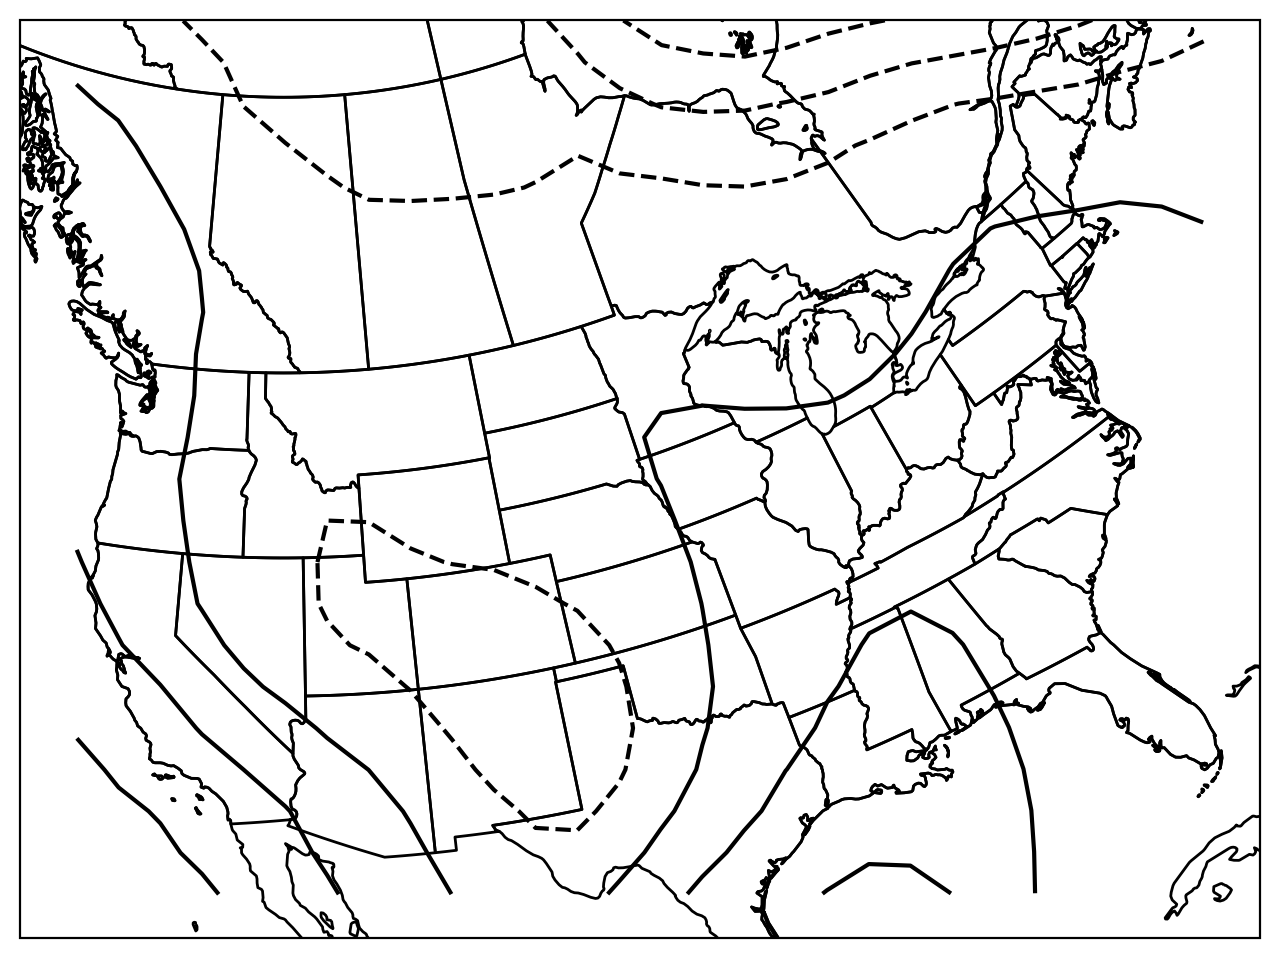

In [448]:
### Plot 500mb analyses over a map ###
#use old code...

proj = ccrs.Stereographic(central_longitude=-115,central_latitude=90,true_scale_latitude=60)
fig = plt.figure(figsize=(8,8),dpi=200)
ax1 = fig.add_subplot(111,projection=proj)
ax1.add_feature(cfeature.STATES)
ax1.add_feature(cfeature.COASTLINE)

#plot analysis (MAY NEED TO CHANGE VARIABLE NAMES/INDICES)#
cs1 = ax1.contour(lamda,psi,f_a_diff[:,:],colors='k',transform=ccrs.PlateCarree())
plt.clabel(cs1,levels=np.arange())
plt.show()

In [ ]:
### Plot Analysis Differences ###


In [ ]:
### Store the analyses in text files ###
with open('analyses_10cm.txt','wb') as f:
    for line in analysis_10:
        np.savetxt(f, line, fmt='%.2f')

with open('analyses_20cm.txt','wb') as f:
    for line in analysis_20:
        np.savetxt(f, line, fmt='%.2f')


In [ ]:
### Store the difference fields in text files ###
with open('analyses_10cm.txt','wb') as f:
    for line in analysis_10:
        np.savetxt(f, line, fmt='%.2f')

with open('analyses_20cm.txt','wb') as f:
    for line in analysis_20:
        np.savetxt(f, line, fmt='%.2f')


In [ ]:
### Store RMS values in text file ###
with open('analyses_10cm.txt','wb') as f:
    for line in analysis_10:
        np.savetxt(f, line, fmt='%.2f')

with open('analyses_20cm.txt','wb') as f:
    for line in analysis_20:
        np.savetxt(f, line, fmt='%.2f')


In [ ]:
### In a separte text file (or below), answer the following questions ###
'''
1 - Describe the general features that you see in your contoured analyses.
    

2 - Describe the differences that you see in your contoured analyses.  
    Does one analysis seem to be smoother than the other?  If so, what would cause this?
    

3 - What happens as you increase the number of successive correction passes?  Is this 
    desirable?  Why or why not?
    

'''